# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

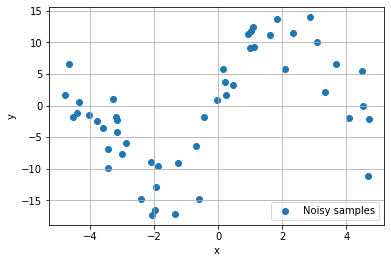

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

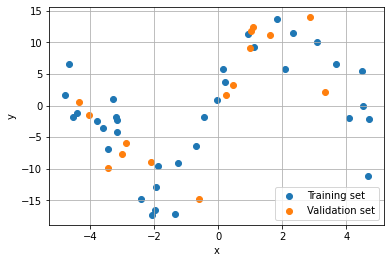

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
y_train

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

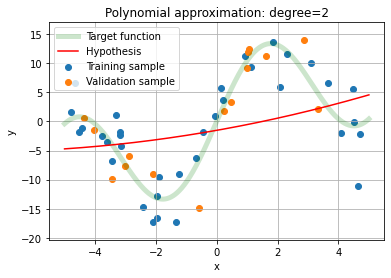

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

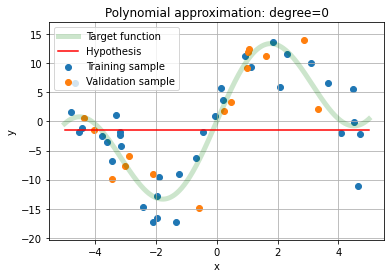

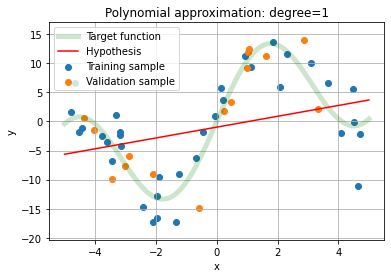

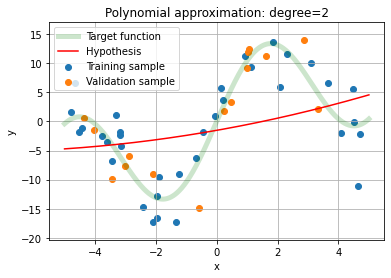

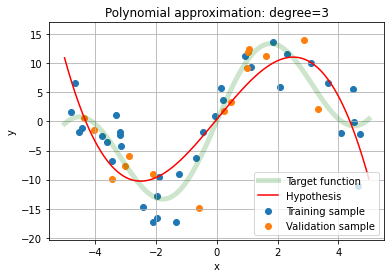

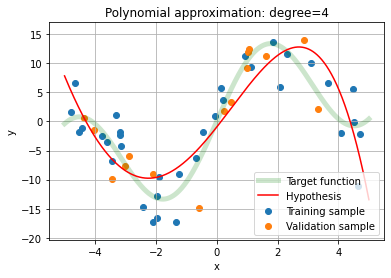

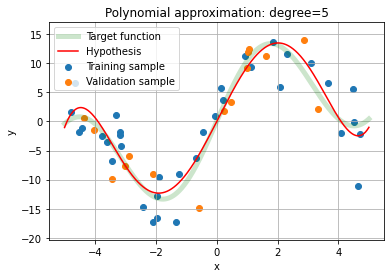

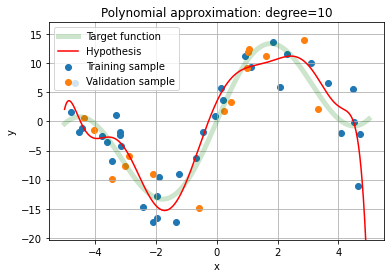

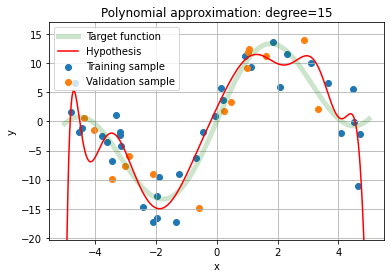

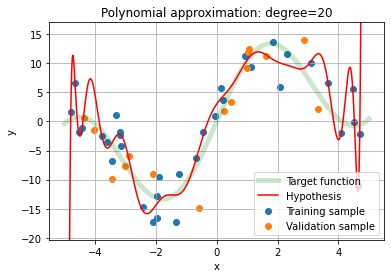

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

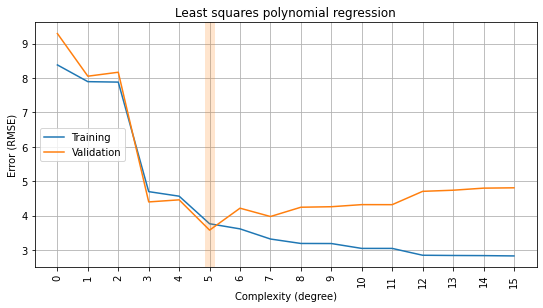

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

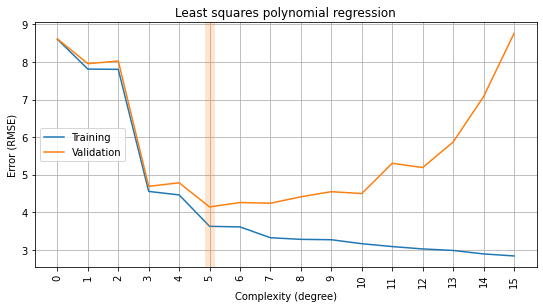

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

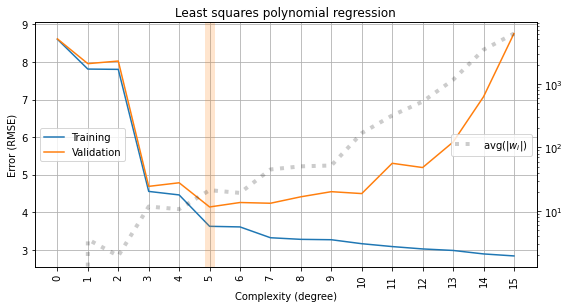

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

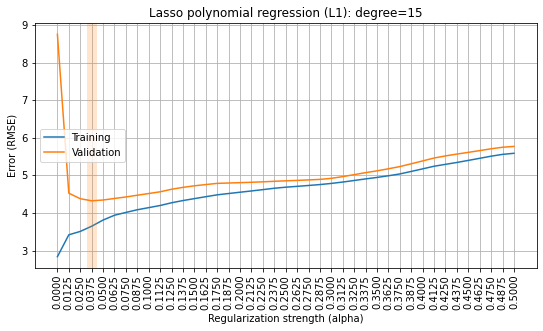

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

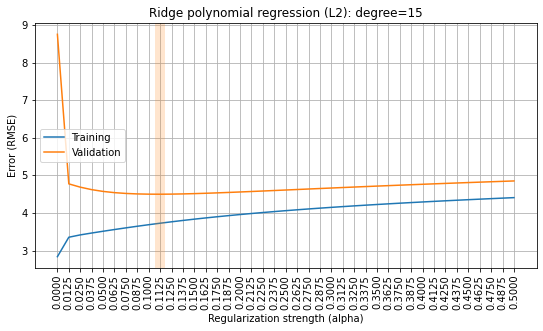

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

For not overwrite funtion *plot_fitting_graph* let's accept our validation error to be test error.

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)

We have to delete degree = 0 from DEGREES, becuase it doesn't work on PolynomialFeatures.

In [22]:
DEGREES = np.linspace(1, 15, 1 + 14, dtype=int)

Because of the problems with computer functionality let's break into pieces DEGREES and run the function for DEGREES[:9] first, then DEGREES[9:14] and last with 15 degrees.

In [23]:
print(DEGREES[:9])
print(DEGREES[9:14])

[1 2 3 4 5 6 7 8 9]
[10 11 12 13 14]


In [24]:
rmse_train, rmse_valid = [], []
for degree in DEGREES[:9]:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))

In [25]:
for degree in DEGREES[9:14]:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))

In [26]:
reg = make_model(degree=15).fit(X_train, y_train)
rmse_train.append(rmse(reg.predict(X_train), y_train))
rmse_valid.append(rmse(reg.predict(X_valid), y_valid))

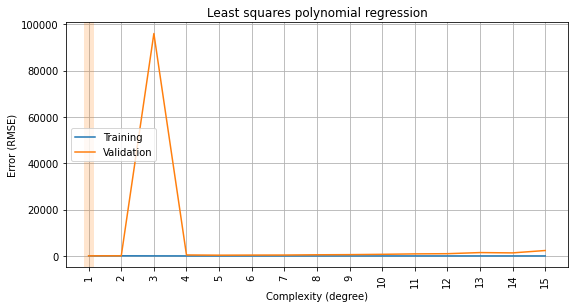

In [27]:
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

It's a huge value of test (validation) RMSE with degree = 3, seems like in this case model has enormous overfitting.

That's why we cannot see clear other values (because of the scale). So, let's kick degree = 3 off.

In [28]:
DEGREES = np.delete(DEGREES, [2])
rmse_train = np.delete(rmse_train, [2])
rmse_valid = np.delete(rmse_valid, [2])

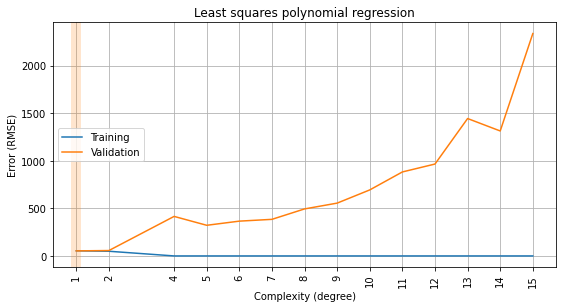

In [29]:
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

**your findings/conclusions**

From the plot we see that with the increasing of degree model starts to be overfitting. And the best choise is with degree = 1

With the value of degree = 15 we can see how the validation error is far from the test error, that means that model is overfited. 

Also we saw some enormous values of validation error with degree = 3. Much more than with degree = 15. I think, that it's because of the way of train set splitted. Maybe it had some specific values, that there wasn't in validation set, or conversely. Maybe in this case it would be better decision to use cross validation. Let's check out.

Because of the lack computer power it's impossible for me to run cross-validation function with so much variables and degree=15. In this case I chose one feature randomly to compute values for PolynomialFeatures with degree = 15. I will collect all features together later.

Let's choose poly feature in *X_poly_features*

and the rest collect in *X_lin_features*.

In [30]:
X_poly_features = X_diabetes[['s2']]
X_lin_features = X_diabetes[['age', 'sex', 'bmi', 'bp', 's1', 's3', 's4', 's5', 's6']]

In [31]:
DEGREES = np.linspace(1, 15, 1 + 14, dtype=int)

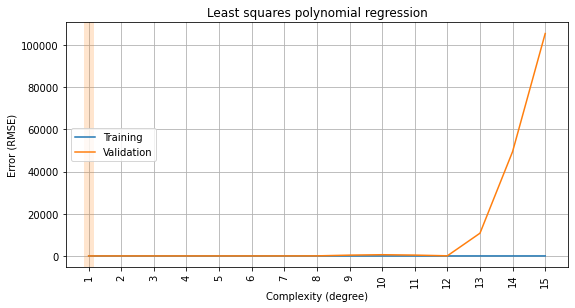

In [32]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    #compute PolynomialFeatures with differet degrees
    my_model_poly = PolynomialFeatures(degree, include_bias=False)
    new_poly_features = my_model_poly.fit_transform(X_poly_features)
    X_new_poly_features = pd.DataFrame(new_poly_features)
    #combine all features back together
    X_poly_plus_lin_task_1 = X_lin_features.join(X_new_poly_features)
    #making cross validation
    results = cross_validate(make_model(degree=1), 
                             X_poly_plus_lin_task_1, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Now it seems much better. And we see that the best option is still with degree = 1. And further with the increasing of degree the model is becoming more overfited.

Let's calculate the difference between train and validation error for latest comparings.

In [33]:
np.abs(rmse_train[0] - rmse_valid[0])

1.350240917126122

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

In [34]:
#computing PolynomialFeatures in X_poly_features with degree=15
my_model_poly = PolynomialFeatures(15, include_bias=False)
new_poly_features = my_model_poly.fit_transform(X_poly_features)
X_new_poly_features = pd.DataFrame(new_poly_features)
X_new_poly_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.034821,0.001212,-4.221967e-05,1.470121e-06,-5.119074e-08,1.782501e-09,-6.206803e-11,2.161256e-12,-7.525659e-14,2.620492e-15,-9.124752e-17,3.177308e-18,-1.106363e-19,3.852440e-21,-1.341449e-22
1,-0.019163,0.000367,-7.037422e-06,1.348605e-07,-2.584378e-09,4.952531e-11,-9.490703e-13,1.818736e-14,-3.485305e-16,6.679008e-18,-1.279921e-19,2.452756e-21,-4.700300e-23,9.007345e-25,-1.726108e-26
2,-0.034194,0.001169,-3.998227e-05,1.367172e-06,-4.674973e-08,1.598582e-09,-5.466266e-11,1.869161e-12,-6.391495e-14,2.185537e-15,-7.473329e-17,2.555465e-18,-8.738275e-20,2.988007e-21,-1.021733e-22
3,0.024991,0.000625,1.560737e-05,3.900374e-07,9.747266e-09,2.435900e-10,6.087458e-12,1.521292e-13,3.801799e-15,9.500920e-17,2.374336e-18,5.933608e-20,1.482844e-21,3.705714e-23,9.260800e-25
4,0.015596,0.000243,3.793598e-06,5.916549e-08,9.227532e-10,1.439139e-11,2.244501e-13,3.500555e-15,5.459514e-17,8.514735e-19,1.327970e-20,2.071120e-22,3.230148e-24,5.037784e-26,7.856999e-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,-0.002566,0.000007,-1.690477e-08,4.338560e-11,-1.113479e-13,2.857712e-16,-7.334236e-19,1.882310e-21,-4.830896e-24,1.239836e-26,-3.182002e-29,8.166517e-32,-2.095913e-34,5.379101e-37,-1.380531e-39
438,0.079165,0.006267,4.961400e-04,3.927706e-05,3.109379e-06,2.461549e-07,1.948692e-08,1.542687e-09,1.221273e-10,9.668239e-12,7.653888e-13,6.059222e-14,4.796800e-15,3.797400e-16,3.006222e-17
439,-0.013840,0.000192,-2.650885e-06,3.668776e-08,-5.077519e-10,7.027193e-12,-9.725506e-14,1.345992e-15,-1.862828e-17,2.578120e-19,-3.568071e-21,4.938144e-23,-6.834300e-25,9.458546e-27,-1.309045e-28
440,0.015283,0.000234,3.569645e-06,5.455486e-08,8.337614e-10,1.274237e-11,1.947415e-13,2.976233e-15,4.548574e-17,6.951581e-19,1.062410e-20,1.623679e-22,2.481468e-24,3.792425e-26,5.795960e-28


Let's collect all features together.

In [35]:
X_poly_plus_lin = X_lin_features.join(X_new_poly_features)
X_poly_plus_lin 

,age,sex,bmi,bp,s1,s3,s4,s5,s6,0,...,5,6,7,8,9,10,11,12,13,14
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.043401,-0.002592,0.019908,-0.017646,-0.034821,...,1.782501e-09,-6.206803e-11,2.161256e-12,-7.525659e-14,2.620492e-15,-9.124752e-17,3.177308e-18,-1.106363e-19,3.852440e-21,-1.341449e-22
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,0.074412,-0.039493,-0.068330,-0.092204,-0.019163,...,4.952531e-11,-9.490703e-13,1.818736e-14,-3.485305e-16,6.679008e-18,-1.279921e-19,2.452756e-21,-4.700300e-23,9.007345e-25,-1.726108e-26
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.032356,-0.002592,0.002864,-0.025930,-0.034194,...,1.598582e-09,-5.466266e-11,1.869161e-12,-6.391495e-14,2.185537e-15,-7.473329e-17,2.555465e-18,-8.738275e-20,2.988007e-21,-1.021733e-22
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,-0.036038,0.034309,0.022692,-0.009362,0.024991,...,2.435900e-10,6.087458e-12,1.521292e-13,3.801799e-15,9.500920e-17,2.374336e-18,5.933608e-20,1.482844e-21,3.705714e-23,9.260800e-25
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.008142,-0.002592,-0.031991,-0.046641,0.015596,...,1.439139e-11,2.244501e-13,3.500555e-15,5.459514e-17,8.514735e-19,1.327970e-20,2.071120e-22,3.230148e-24,5.037784e-26,7.856999e-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.028674,-0.002592,0.031193,0.007207,-0.002566,...,2.857712e-16,-7.334236e-19,1.882310e-21,-4.830896e-24,1.239836e-26,-3.182002e-29,8.166517e-32,-2.095913e-34,5.379101e-37,-1.380531e-39
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,-0.028674,0.034309,-0.018118,0.044485,0.079165,...,2.461549e-07,1.948692e-08,1.542687e-09,1.221273e-10,9.668239e-12,7.653888e-13,6.059222e-14,4.796800e-15,3.797400e-16,3.006222e-17
439,0.041708,0.050680,-0.015906,0.017282,-0.037344,-0.024993,-0.011080,-0.046879,0.015491,-0.013840,...,7.027193e-12,-9.725506e-14,1.345992e-15,-1.862828e-17,2.578120e-19,-3.568071e-21,4.938144e-23,-6.834300e-25,9.458546e-27,-1.309045e-28
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,-0.028674,0.026560,0.044528,-0.025930,0.015283,...,1.274237e-11,1.947415e-13,2.976233e-15,4.548574e-17,6.951581e-19,1.062410e-20,1.623679e-22,2.481468e-24,3.792425e-26,5.795960e-28


#### L1

Let's make a model where we will use L1 regularization for different ALPHAS with cross validation for our combined dataset.

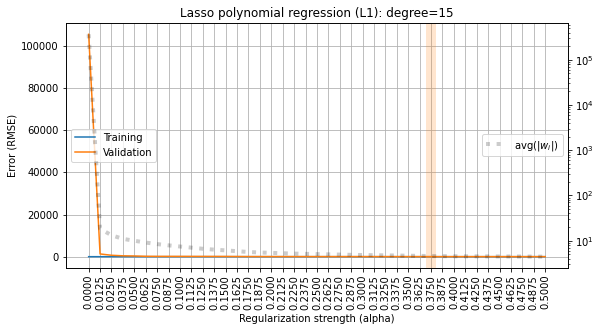

In [36]:
rmse_train, rmse_valid, avg_coef = [], [], [] 
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha), 
                             X_poly_plus_lin, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

We can see that even with degree=15 (where we saw the huge overfitting without regularization) now a difference between test and validation errors is not so big.

Weights are getting smaller with increasing of regularization strength. So, we can say that lasso tend to constraint the weights

Also we calculated the best option of alpha (=0.375) where we have the least difference between errors. Let's calculate the difference.

In [37]:
np.abs(rmse_train[30] - rmse_valid[30])

20.59307614983556

#### L2

Now let's do the same but using L2 regularization.

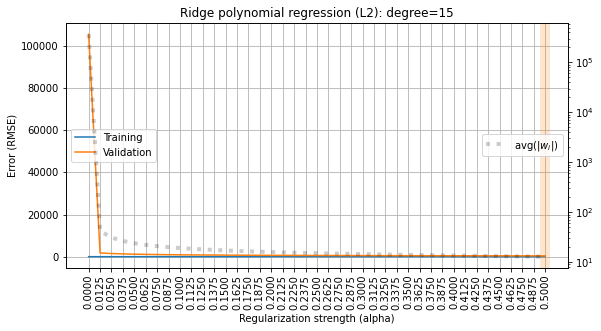

In [38]:
rmse_train, rmse_valid, avg_coef = [], [], [] 
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha), 
                             X_poly_plus_lin, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

The picture is almost like with L1. 

The weights are also decreasing with larger alphas.

Now we have the other best value of alpha parametr (=0.5 and maybe while making further discovering we might try to use bigger values).

As earlier let's calculate the differece between train and validation errors.

In [39]:
np.abs(rmse_train[len(rmse_train) - 1] - rmse_valid[len(rmse_train) - 1])

393.92522459631545

#### Summary

**your observations/conclusions:**

Looking at the plots with regularization and without for degree = 15 we can confidently say that regularization methods help the model to constraint the weights. We may use it to avoid overfitting.

But let's find out where we had the least difference between errors?

Model with degree=1: difference 1.350240917126122

Model with degree=15 and L1: 20.59307614983556

Model with degree=15 and L2: 393.92522459631545

Obviously, although regularization is very helpful and makes model more confident it's better to use model of degree where the overfitting is the least.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Let's build plots the same as in the exercise 2 for L1 and L2 methods.

But this time we build a line not with the average value of weights but with a **number of weights which are equal to zero**.

This way we can compare L1 and L2 in producing weights = 0.

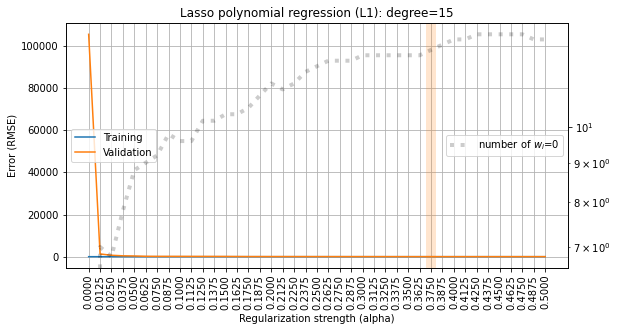

In [40]:
rmse_train, rmse_valid, zero_coef = [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model(degree=1, penalty='L1', alpha=alpha),
                             X_poly_plus_lin, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    zero_coef_i = []
    for model in results['estimator']:
        zero_coef_i.append(model['reg'].coef_[np.where(model['reg'].coef_ == 0)].size) 
    zero_coef.append(np.mean(zero_coef_i))
    

plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=zero_coef, custom_label='number of $w_i$=0',
                   title='Lasso polynomial regression (L1): degree=15')

Sure, with increasing of alpha also a number of weights wich are equal to zero is increasing.

#### L2

Let's do same for L2 regularization.

C:\Users\Kate\anaconda3\lib\site-packages\ipykernel\pylab\backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


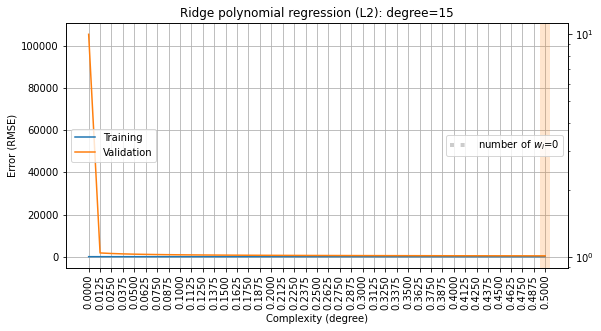

In [41]:
rmse_train, rmse_valid, zero_coef = [], [], []
for alpha in ALPHAS:
    results = cross_validate(make_model(degree=1, penalty='L2', alpha=alpha),
                             X_poly_plus_lin, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    zero_coef_i = []
    for model in results['estimator']:
        zero_coef_i.append(model['reg'].coef_[np.where(model['reg'].coef_ == 0)].size) 
    zero_coef.append(np.mean(zero_coef_i))
    

plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=zero_coef, custom_label='number of $w_i$=0',
                   title='Ridge polynomial regression (L2): degree=15')

Let's see, we have **warning** about some data that has no positive values. And it seems like it refers to number of zero values in weights because two other lines were ploted well.

Let's check out a list with numbers of zero weights:

In [42]:
print(zero_coef)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


The case is that the Rigre regularization didn't produce no one zero weight.

#### Summary

**your findings/conclusions**

We can surely say that because of the tendings of Lasso to produce weights = 0 for features which have the least influence at target --- Lasso can also be used for feature selection.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [43]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


First let's choose a degree where the model will be more overfitted to have a possibility to feel an influence of scaling.

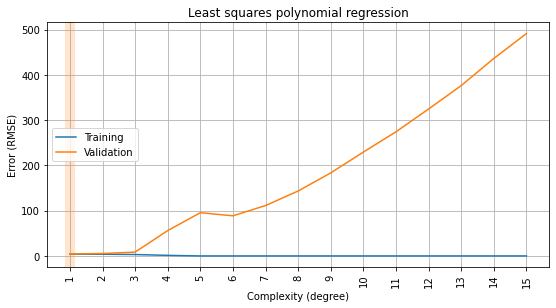

In [44]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

If the target was to build a perfect model we would choose a degree = 1.

But in our case we will choose degree = 15 to be able to see the difference.

Let's write a function of making model without StandardScaler. We will increase a little a value of max_iter because this model will probably need much more iterations.

In [45]:
def make_model_without_scaler(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=100000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=100000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('reg', regressor)
    ])

display(make_model_without_scaler(2))
display(make_model_without_scaler(2, penalty='L1', alpha=0.1))
display(make_model_without_scaler(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', Lasso(alpha=0.1, max_iter=100000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('reg', Ridge(alpha=0.1, max_iter=100000, random_state=42))])

It'll be interesting to know how many time it takes the calculations with and without StandardScaler. So, let's import datetime library to be able to detect time.

In [46]:
from datetime import datetime
import time

#### L1

First, let's make a model with new datas using StandardScaler.

Time of program working 0:00:09.214582


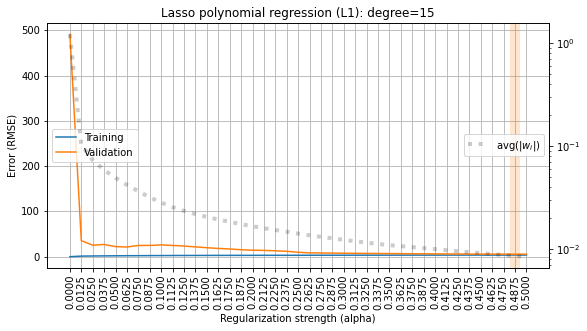

In [47]:
rmse_train, rmse_valid, avg_coef = [], [], []
start_time = datetime.now()
for alpha in ALPHAS:  
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

print(f'Time of program working {datetime.now() - start_time}')
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1): degree=15')

Let's print coefficients for models where alpha is the best (0.4875).

In [48]:
results = cross_validate(make_model(degree=15, penalty='L1', \
                                                   alpha=0.4875),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
coeff_scaler = []
for model in results['estimator']:
    coeff_scaler.append(np.mean(np.abs(model['reg'].coef_)))
coeff_scaler

[0.007838182323962571,
 0.008472305487314558,
 0.008965334473051301,
 0.009099931859000833,
 0.008160430415641762]

Now let's repeat the same steps but for model without StandardScaler:

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1481202121808467, tolerance: 0.14576113040885222
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1232186312450432, tolerance: 0.17421451253800888
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6560527756654935, tolerance: 0.18167775802316388
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7902213054274663, tolerance: 0.14576113040885222
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5232488179197312, tolerance: 0.17421451253800888
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.513843588820358, tolerance: 0.16621139321816308
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.086792578450361, tolerance: 0.18167775802316388
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3778229565698905, tolerance: 0.18162747646095764
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.825477253965602, tolerance: 0.14576113040885222
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.092053498898058, tolerance: 0.17421451253800888
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8693622767121825, tolerance: 0.16621139321816308
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8885828041121795, tolerance: 0.18167775802316388
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4346269751371301, tolerance: 0.18162747646095764
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3905353025326925, tolerance: 0.14576113040885222
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2171111597641961, tolerance: 0.17421451253800888
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9366507742878493, tolerance: 0.16621139321816308
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0171942756161823, tolerance: 0.18167775802316388
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49371531285346765, tolerance: 0.18162747646095764
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: Convergence

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.51167325703818, tolerance: 0.14576113040885222
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1626612715095952, tolerance: 0.17421451253800888
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8493293491094922, tolerance: 0.16621139321816308
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWar

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3429923071531236, tolerance: 0.18167775802316388
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5761567559980678, tolerance: 0.18162747646095764
  model = cd_fast.enet_coordinate_descent(


Time of program working 0:17:11.092051


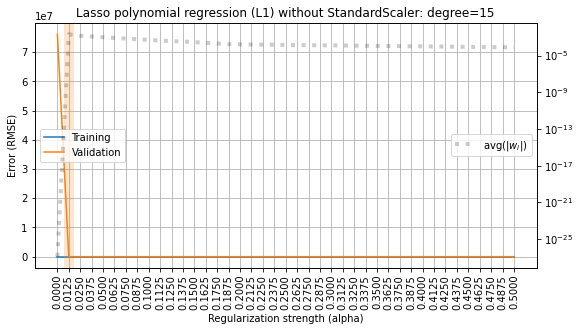

In [49]:
rmse_train, rmse_valid, avg_coef = [], [], []
start_time = datetime.now()
for alpha in ALPHAS:  
    results = cross_validate(make_model_without_scaler(degree=15, penalty='L1', alpha=alpha),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
print(f'Time of program working {datetime.now() - start_time}')
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1) without StandardScaler: degree=15')

Even we've incresed the amount of max_iter we have a lot of warnings that it's not enough. 

And the time of cicle working is much more large now (17,5 min compared to 9 sec with scaling).

Let's print the coefficients now:

In [50]:
results = cross_validate(make_model_without_scaler(degree=15, penalty='L1', \
                                                   alpha=0.0125),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
coeff_without_scaler = []
for model in results['estimator']:
    coeff_without_scaler.append(np.mean(np.abs(model['reg'].coef_)))
coeff_without_scaler

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1481202121808467, tolerance: 0.14576113040885222
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1232186312450432, tolerance: 0.17421451253800888
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6560527756654935, tolerance: 0.18167775802316388
  model = cd_fast.enet_coordinate_descent(
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceW

[0.0027637091148557833,
 0.002720113067410089,
 0.0003291495301977248,
 0.0039789814078505315,
 0.0005181563468225754]

Now coefficients are smaller and some of them are smaller ten times.

Also, coefficients have different order $10^{-3}$ and $10^{-4}$.

#### L2

And now the same for L2 regularizer.

First, with StandardScaler.

Time of program working 0:00:00.696428


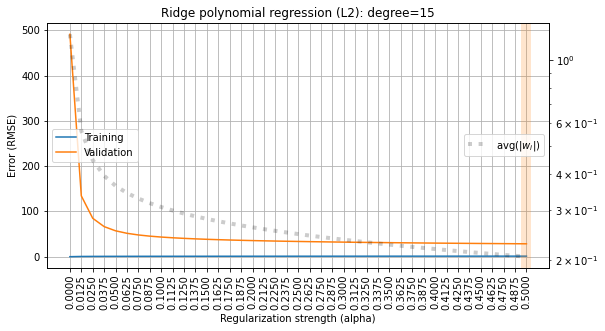

In [51]:
rmse_train, rmse_valid, avg_coef = [], [], []
start_time = datetime.now()
for alpha in ALPHAS:  
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

print(f'Time of program working {datetime.now() - start_time}')
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2): degree=15')

Coefficients in the best solution:

In [52]:
results = cross_validate(make_model(degree=15, penalty='L2', alpha=0.5),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
coeff_scaler = []
for model in results['estimator']:
    coeff_scaler.append(np.mean(np.abs(model['reg'].coef_)))
coeff_scaler

[0.17916032063168869,
 0.20423896663410707,
 0.18970079032836537,
 0.24819585876463862,
 0.20573237205963218]

And now without StandardScaler:

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear

Time of program working 0:00:00.584761


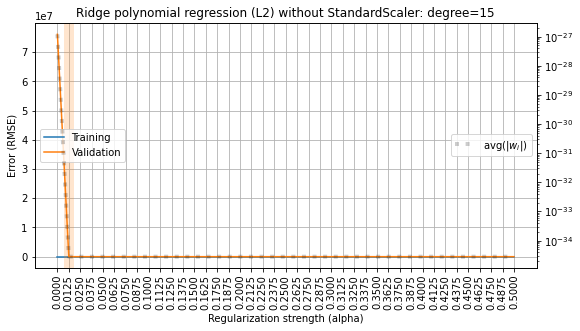

In [53]:
rmse_train, rmse_valid, avg_coef = [], [], []
start_time = datetime.now()
for alpha in ALPHAS:  
    results = cross_validate(make_model_without_scaler(degree=15, penalty='L2', alpha=alpha),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
print(f'Time of program working {datetime.now() - start_time}')
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2) without StandardScaler: degree=15')

Coefficients:

In [54]:
results = cross_validate(make_model_without_scaler(degree=15,  \
                                                   penalty='L2', alpha=0.0125),
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
coeff_without_scaler = []
for model in results['estimator']:
    coeff_without_scaler.append(np.mean(np.abs(model['reg'].coef_)))
coeff_without_scaler

C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\Kate\anaconda3\lib\site-packages\sklearn\linear

[3.365086718049938e-35,
 2.4873051590783033e-35,
 3.9955661035122303e-35,
 9.775884683370439e-36,
 3.256119107809833e-35]

Now we haven't so large difference between time of cycle working. But in case with L2 regularizer we have much more difference between coefficients, which are really smaller in case without regularization. Also, as in case of L1, coefficients have different order.

#### Summary



**your observations/conclusions**:

Coefficient of models without StandardScaler have much more variance between itselfs.

Also smaller coefficients (having order $10^{-35}$) is worse for the model, and in our case, model without standardizing the inputs tends to produce smaller coefficients. In case with scaling the inputs we have much more confident model.

As the second reason to choose StandardScaler we can say that it takes much more time and computer resources to build models without scaling.

On the whole inputs **with** using StandardScaler have zero mean and unit variance which make the estimator be able to learn evenly for all features. While **without** it if inputs have a variance that is orders of magnitude larger than other inputs, it might dominate the objective function and make the estimator unable to learn from other features correctly.